# Fall 2020: DS-GA 1011 NLP with Representation Learning
## Lab 7: 16-Oct-2020, Friday
## Recurrent Neural Networks with Pytorch
In this lab, we explore how to implement RNN based Language Model with sequential data.

Examples of **sequential data**: 

- discrete: text

- continuous: 1d audio, 2d image, 3d video

In [1]:
# !conda install -c conda-forge jsonlines #OR
!pip install jsonlines

In [2]:
#Import required packages
import os
import jsonlines
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy
import matplotlib.pyplot as plt

c.f
> [`torch.utils.data`](https://pytorch.org/docs/stable/data.html) provides PyTorch data loading utility. The key-class of this module is the `torch.utils.data.DataLoader`.


---
### Dataset
We will use **Persona-Chat** again.

In [3]:
# Download data and a pretrained model

# dwnld_path = './data/personachat/'

### DOWNLOADING THE FILES
### persona chat dataset
if not os.path.exists('personachat_all_sentences_train.jsonl'):
    !wget "https://nyu.box.com/shared/static/q4nvswb0szelivhgyx87vd1056ttqfyi.jsonl" -O 'personachat_all_sentences_train.jsonl'
if not os.path.exists('personachat_all_sentences_valid.jsonl'):
    !wget "https://nyu.box.com/shared/static/8krcizo8sms1m0ppy7uiwfcx4a3l5nsq.jsonl" -O 'personachat_all_sentences_valid.jsonl'
if not os.path.exists('personachat_all_sentences_test.jsonl'):
    !wget "https://nyu.box.com/shared/static/im7we9k2gcf8kslqnfamsimicgosuw9y.jsonl" -O 'personachat_all_sentences_test.jsonl'

### pretrained rnn model
if not os.path.exists('personachat_rnn_lm.pt'):
    !wget "https://nyu.box.com/shared/static/3jl9erctnvbefnczgmetkdil0xwpcxzb.pt" -O 'personachat_rnn_lm.pt'

--2021-07-30 16:07:41--  https://nyu.box.com/shared/static/q4nvswb0szelivhgyx87vd1056ttqfyi.jsonl
Resolving nyu.box.com (nyu.box.com)... 107.152.24.197
Connecting to nyu.box.com (nyu.box.com)|107.152.24.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/q4nvswb0szelivhgyx87vd1056ttqfyi.jsonl [following]
--2021-07-30 16:07:41--  https://nyu.box.com/public/static/q4nvswb0szelivhgyx87vd1056ttqfyi.jsonl
Reusing existing connection to nyu.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://nyu.app.box.com/public/static/q4nvswb0szelivhgyx87vd1056ttqfyi.jsonl [following]
--2021-07-30 16:07:42--  https://nyu.app.box.com/public/static/q4nvswb0szelivhgyx87vd1056ttqfyi.jsonl
Resolving nyu.app.box.com (nyu.app.box.com)... 107.152.24.201
Connecting to nyu.app.box.com (nyu.app.box.com)|107.152.24.201|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://public.boxcloud

In [ ]:
# For Windows users
# !pip install wget
# import wget

# # Download data and a pretrained model

# ### DOWNLOADING THE FILES
# ### persona chat dataset
# if not os.path.exists('personachat_all_sentences_train.jsonl'):
#     wget.download("https://nyu.box.com/shared/static/q4nvswb0szelivhgyx87vd1056ttqfyi.jsonl",'personachat_all_sentences_train.jsonl')
# if not os.path.exists('personachat_all_sentences_valid.jsonl'):
#     wget.download("https://nyu.box.com/shared/static/8krcizo8sms1m0ppy7uiwfcx4a3l5nsq.jsonl",'personachat_all_sentences_valid.jsonl')
# if not os.path.exists('personachat_all_sentences_test.jsonl'):
#     wget.download("https://nyu.box.com/shared/static/im7we9k2gcf8kslqnfamsimicgosuw9y.jsonl",'personachat_all_sentences_test.jsonl')

# ## wikitext-2 dataset
# if not os.path.exists('wikitext2-sentencized.json'):
#     wget.download("https://nyu.box.com/shared/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json",'wikitext2-sentencized.json')

# ### pretrained rnn model
# if not os.path.exists('personachat_rnn_lm.pt'):
#     wget.download("https://nyu.box.com/shared/static/3jl9erctnvbefnczgmetkdil0xwpcxzb.pt",'personachat_rnn_lm.pt')

#### Preparing data: dictionary and dataset

In [4]:
def load_personachat(basedir):
    datasets_fnames = {
        'train': os.path.join(basedir, 'personachat_all_sentences_train.jsonl'),
        'valid': os.path.join(basedir, 'personachat_all_sentences_valid.jsonl'),
        'test': os.path.join(basedir, 'personachat_all_sentences_test.jsonl'),
    }
    
    datasets_text = {
        'train': [],
        'valid': [],
        'test': [],
    }
    
    for split, fname in datasets_fnames.items():
        for token_dict in jsonlines.open(fname):
            datasets_text[split].append(token_dict['tokens'])
    
    return datasets_text

class Dictionary(object): #maps words to indices
    def __init__(self, datasets, include_valid=False):
        self.tokens = []
        self.ids = {}
        self.counts = {}
        
        # add special tokens
        self.add_token('<bos>') #beginning of sentence
        self.add_token('<eos>') #end of sentence
        self.add_token('<pad>')
        self.add_token('<unk>') #unknown. Needed in case use with text with word that isn't in vocab
        
        for line in tqdm(datasets['train']):
            for w in line:
                self.add_token(w)
                    
        if include_valid is True:
            for line in tqdm(datasets['valid']):
                for w in line:
                    self.add_token(w)
                            
    def add_token(self, w):
        if w not in self.tokens:
            self.tokens.append(w)
            _w_id = len(self.tokens) - 1
            self.ids[w] = _w_id
            self.counts[w] = 1
        else:
            self.counts[w] += 1

    def get_id(self, w):
        return self.ids[w]
    
    def get_token(self, idx):
        return self.tokens[idx]
    
    def decode_idx_seq(self, l):
        return [self.tokens[i] for i in l]
    
    def encode_token_seq(self, l):
        return [self.ids[i] if i in self.ids else self.ids['<unk>'] for i in l]
    
    def __len__(self):
        return len(self.tokens)

In [5]:
personachat_dataset = load_personachat('./')
persona_dict = Dictionary(personachat_dataset, include_valid=True)

100%|██████████| 16181/16181 [00:03<00:00, 4310.84it/s]


In [6]:
print(len(persona_dict))
for i in range(10):
    print(i, persona_dict.get_token(i))

20089
0 <bos>
1 <eos>
2 <pad>
3 <unk>
4 i
5 am
6 doing
7 great
8 except
9 for


---
### Model: Recurrent Neural Network

#### RNN as a sequence processing tool

Consider a sequential input $\mathbf{x}_1^T = (x_1, x_2, \cdots, x_T)$.

Now our goal is to estimate the probability distribution $p(x_t|x_{<t})$, i.e. the history is full prefix of the input before the token $x_t$. Obviosuly, in this case every token's history depends on the particular input and token position.

Recurrent neural network can be seen as a function $h_t = f(x_t, h_{t-1}; \theta)$, where $h_t$ is an internal (hidden) state of the model at time step $t$, and $x_t$ is an input signal at time step $t$.

How exactly is $f$ defined? It depends on a particular architecture. There are plenty of them such as Long Short-Term Memory (LSTM), Gated Recurrent Unit (GRU) etc.

Consider the simplest possible case: $$h_t = f(x_t, h_{t-1}; \theta) = \text{tanh}(a_t)\\ a_t = b + W \cdot h_{t-1} + U \cdot x_t$$ Adding previous hidden state

Lets assume that size of the hidden state $|h_t| = 32$. ***Then what is the dimensionality of $W$?*** $dim(o)\times dim(h)$

What about $x_t$? In count based LM each token is represented by a single number? Here we use the distributional representation of the token.

Lets assume size of the token embedding here $|x_t| = 300$. ***Then what is the dimensionality of $U$?***

***Then what is the dimensionality of $b$?***

#### RNNCell

*RNNCell* is a building block of the RNN model. Pytorch RNN model allows to create multi-layer network, i.e. it creates a separate RNNCell for every layer and is able to process the whole sequences of data by iteratively applying RNNCell step by step.

In [7]:
from torch.nn import RNNCell 

#  always try to read the documentation 
RNNCell?

***Why there are two bias terms in Elman RNNCell? Is this equivalent to a single bias term as we wrote? Why?***

In [8]:
# quick test
hidden_size = 32
embed_size = 300

rnn_cell = RNNCell(embed_size, hidden_size)
rnn_cell

RNNCell(300, 32)

In [9]:
random_hidden = torch.rand(1, hidden_size)
print(random_hidden.size())

torch.Size([1, 32])


In [10]:
random_input = torch.rand(1, embed_size)
print(random_input.size())

torch.Size([1, 300])


In [11]:
new_hidden = rnn_cell(random_input, random_hidden)
print(new_hidden.size())

torch.Size([1, 32])


***What is the first 1 in the size tuple?*** -> *Batch size*. 

#### Batch size


*Batch size* is the number of elements that *mini batch* contains. Do not confuse the batch size and time/sequence axis.

Why do we need a *batch size*? To save computation time. Matrix multiplications give us this speed-up at very low cast thanks to efficient implementations.

Consider the following input batch:

In [12]:
example_2 = [ 'hello this is the first sample in mini batch', 'and this is the second sample in mini batch' ]
example_2

['hello this is the first sample in mini batch',
 'and this is the second sample in mini batch']

This *mini batch* contains two independent sentences, i.e. the batch size is 2. 

The actual length of each sample is 9. We are lucky that they have the same length, but what to do if not? For example:

In [13]:
example_3 = ['this sample is quite long here since we want to address this case', 'this one is short']
example_3

['this sample is quite long here since we want to address this case',
 'this one is short']

As a workaround we introduce the special padding token `<pad>`, then `example_3` will looks as:

In [14]:
# toy function

def pad_strings(minibatch):
    max_len_sample = max(len(i.split(' ')) for i in minibatch)

    result = []
    for line in minibatch:
        line_len = len(line.split(' '))
        padding_str = ' ' + '<pad> '*(max_len_sample-line_len)
        result.append(line+padding_str)
        
    return result

pad_strings(example_3)

['this sample is quite long here since we want to address this case ',
 'this one is short <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> ']

Now at time step $t=4$ input to RNNCell is `[['long'], ['<pad>']]`.

#### RNN
*RNN* is sequence of *RNN cell*.

In [15]:
from torch.nn import RNNBase, RNN

RNNBase.__init__??

In [16]:
RNNBase.forward?

#### Embedding layer

*Embedding layer* serves as a differentiable look-up table. Given the token id, it returns corresponding vector which represents the given word.

Pytorch provides this functionality for us with `torch.nn.Embedding`.

In [17]:
from torch.nn import Embedding

Embedding?

In [18]:
# Example embedding layer

lookup = Embedding(num_embeddings=len(persona_dict), embedding_dim=256, padding_idx=persona_dict.get_id('<pad>')) #you don't want to change embedding padding since there's no info there
lookup

Embedding(20089, 256, padding_idx=2)

In [19]:
lookup.weight.size()

torch.Size([20089, 256])

In [20]:
# Example input

input_ = persona_dict.encode_token_seq('hello world'.split(' '))
print(f'discrete input: {[input_]}')

input_continuous = lookup(torch.tensor([input_], dtype=torch.long))
print(f'continuous input size: {input_continuous.size()}')

discrete input: [[179, 373]]
continuous input size: torch.Size([1, 2, 256])


In [21]:
input_continuous

tensor([[[-1.2950e+00, -1.9721e+00, -6.6614e-01,  6.4192e-01,  4.0356e-01,
           5.0825e-01,  1.0326e-01,  1.2580e+00,  1.1578e+00,  5.9725e-01,
           5.3978e-01, -1.0805e+00, -3.9110e-01, -7.5409e-01,  1.6839e+00,
           5.9826e-01,  7.8554e-02,  2.0559e+00, -3.0464e+00,  5.7640e-01,
          -5.2012e-01,  6.7587e-01, -5.8847e-01,  7.0834e-01, -2.9694e-01,
           2.8198e-02,  9.4362e-02, -1.5469e+00, -3.4083e-01, -6.8557e-02,
          -1.4341e+00,  2.4854e-01, -9.4871e-01, -8.1723e-01,  8.9724e-01,
           2.1568e+00,  8.7390e-01,  2.9091e-01, -2.3783e+00,  5.7108e-01,
          -2.6376e-01, -8.5112e-01,  1.8104e+00, -1.2128e+00,  4.1777e-01,
          -5.6244e-01, -1.4196e-01,  2.1519e+00,  3.1574e-01,  2.5741e+00,
          -5.0429e-01, -1.0325e+00,  1.3688e+00, -3.9417e-01,  6.5481e-01,
          -7.4233e-01,  9.1127e-01, -3.2377e-01,  6.6054e-01,  1.3724e+00,
           2.0172e+00,  7.6719e-01, -1.3609e-01,  1.3865e+00,  1.9432e-01,
          -5.3554e-01,  4

#### Creating the RNN model

In [22]:
input_size = lookup.weight.size(1)
vocab_size = lookup.weight.size(0)
hidden_size = 1024
num_layers = 1

rnn_lm = RNN(input_size, hidden_size, num_layers, batch_first=True) #batchfirst is important - tells you dimension that minibatch is on. Will give model if have it backward but will be wrong. We create batch in loader

In [23]:
rnn_lm

RNN(256, 1024, batch_first=True)

In [24]:
from torch.nn import Linear
# linear projection layer is needed to convert the hidden representation into the token-level output probability distribution

projection = Linear(hidden_size, vocab_size, bias=True)

In [25]:
projection

Linear(in_features=1024, out_features=20089, bias=True)



---



### Customize our model

Now we know how to define each part of LM. Next we are going to make an abstract LM module with all previously discussed parts, as well as data loader which pads and make batches out of our training data.

#### Dataset
Making an efficient dataset using `torch.utils.data.DataLoader`

cf. 
> [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) combines a dataset and a sampler, and provides an iterable over the given dataset.

In [26]:
def tokenize_dataset(datasets, dictionary, ngram_order=2): #substitute words with numbers. Sometimes can include splitting strings, dealing with punctuation and symbols.
    tokenized_datasets = {}
    for split, dataset in datasets.items():
        _current_dictified = []
        for l in tqdm(dataset):
            l = ['<bos>']*(ngram_order-1) + l + ['<eos>']
            encoded_l = dictionary.encode_token_seq(l)
            _current_dictified.append(encoded_l)
        tokenized_datasets[split] = _current_dictified
        
    return tokenized_datasets

In [27]:
class TensoredDataset(Dataset):
    def __init__(self, list_of_lists_of_tokens):
        self.input_tensors = []
        self.target_tensors = []
        
        for sample in list_of_lists_of_tokens:
            self.input_tensors.append(torch.tensor([sample[:-1]], dtype=torch.long))
            self.target_tensors.append(torch.tensor([sample[1:]], dtype=torch.long))
    
    def __len__(self):
        return len(self.input_tensors)
    
    def __getitem__(self, idx):
        # return a (input, target) tuple
        return (self.input_tensors[idx], self.target_tensors[idx])

In [28]:
personachat_tokenized_datasets = tokenize_dataset(personachat_dataset, persona_dict)
persona_tensor_dataset = {}

for split, listoflists in personachat_tokenized_datasets.items():
    persona_tensor_dataset[split] = TensoredDataset(listoflists)
    
# check the first example
persona_tensor_dataset['train'][0]

100%|██████████| 15608/15608 [00:00<00:00, 222994.43it/s]


(tensor([[ 0,  4,  5,  6,  7,  8,  9, 10, 11, 12]]),
 tensor([[ 4,  5,  6,  7,  8,  9, 10, 11, 12,  1]]))

In [29]:
torch.utils.data.DataLoader?

In [30]:
torch.cat?

In [31]:
def pad_list_of_tensors(list_of_tensors, pad_token):
    max_length = max([t.size(-1) for t in list_of_tensors])
    padded_list = []
    
    for t in list_of_tensors:
        padded_tensor = torch.cat([t, torch.tensor([[pad_token]*(max_length - t.size(-1))], dtype=torch.long)], dim = -1)
        padded_list.append(padded_tensor)
        
    padded_tensor = torch.cat(padded_list, dim=0)
    
    return padded_tensor

def pad_collate_fn(batch):
    # batch is a list of sample tuples
    input_list = [s[0] for s in batch]
    target_list = [s[1] for s in batch]
    
    pad_token = persona_dict.get_id('<pad>')
    #pad_token = 2
    
    input_tensor = pad_list_of_tensors(input_list, pad_token)
    target_tensor = pad_list_of_tensors(target_list, pad_token)
    
    return input_tensor, target_tensor

In [32]:
persona_loaders = {}

batch_size = 128

for split, persona_dataset in persona_tensor_dataset.items():
    persona_loaders[split] = DataLoader(persona_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate_fn)

#### Model
Making our own `nn.Module` model to combine Embedding, RNN and Projection in a single object

Above we have created each part of the language model separately. Further we made a criterion and optimizer which takes every parameter we are going to update with an optimizer. To simplify the whole process now we create an abstract model class which combines all parts in a single RNNLanguageModel object.

In [33]:
class RNNLanguageModel(nn.Module): #RNN is only difference from previous model
    """
    This model combines embedding, rnn and projection layer into a single model
    """
    def __init__(self, options):
        super().__init__()
        
        # create each LM part here 
        self.lookup = nn.Embedding(num_embeddings=options['num_embeddings'], embedding_dim=options['embedding_dim'], padding_idx=options['padding_idx'])
        self.rnn = nn.RNN(options['input_size'], options['hidden_size'], options['num_layers'], dropout=options['rnn_dropout'], batch_first=True)
        self.projection = nn.Linear(options['hidden_size'], options['num_embeddings'])
        
    def forward(self, encoded_input_sequence):
        """
        Forward method process the input from token ids to logits
        """
        embeddings = self.lookup(encoded_input_sequence)
        rnn_outputs = self.rnn(embeddings)
        logits = self.projection(rnn_outputs[0]) #convenient for seq to seq models. check shape of output. lstm gives different
        
        return logits

In [34]:
# Create a model if we do not want to use pretrained model

load_pretrained = True

num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

if load_pretrained:
    if not os.path.exists('personachat_rnn_lm.pt'):
        raise EOFError('Download pretrained model!')
    model_dict = torch.load('personachat_rnn_lm.pt', map_location=current_device)
    
    options = model_dict['options']
    model = RNNLanguageModel(options).to(current_device)
    model.load_state_dict(model_dict['model_dict'])
    
else:
    embedding_size = 256
    hidden_size = 512
    num_layers = 3
    rnn_dropout = 0.3

    options = {
        'num_embeddings': len(persona_dict),
        'embedding_dim': embedding_size,
        'padding_idx': persona_dict.get_id('<pad>'),
        'input_size': embedding_size,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'rnn_dropout': rnn_dropout,
    }

    

    model = RNNLanguageModel(options).to(current_device)

criterion = nn.CrossEntropyLoss(ignore_index=persona_dict.get_id('<pad>'))

model_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(model_parameters, lr=0.001, momentum=0.999)

In [35]:
model

RNNLanguageModel(
  (lookup): Embedding(20089, 256, padding_idx=2)
  (rnn): RNN(256, 512, num_layers=3, batch_first=True, dropout=0.3)
  (projection): Linear(in_features=512, out_features=20089, bias=True)
)

In [36]:
model_dict.keys()

dict_keys(['options', 'loss_cache', 'model_dict'])

In [37]:
model_dict['options']

{'embedding_dim': 256,
 'hidden_size': 512,
 'input_size': 256,
 'num_embeddings': 20089,
 'num_layers': 3,
 'padding_idx': 2,
 'rnn_dropout': 0.3}

#### Training

In [38]:
plot_cache = []

for epoch_number in range(100):
    avg_loss=0
    if not load_pretrained:
        # do train
        model.train()
        train_log_cache = []
        for i, (inp, target) in enumerate(persona_loaders['train']):
            optimizer.zero_grad()
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)
            
            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            
            loss.backward()
            optimizer.step()
            
            train_log_cach.eappend(loss.item())
            
            if i % 100 == 0:
                avg_loss = sum(train_log_cache)/len(train_log_cache)
                print('Step {} avg train loss = {:.{prec}f}'.format(i, avg_loss, prec=4))
                train_log_cache = []
            
    #do valid
    valid_losses = []
    model.eval()
    with torch.no_grad():
        for i, (inp, target) in enumerate(persona_loaders['valid']):
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)

            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            valid_losses.append(loss.item())
        avg_val_loss = sum(valid_losses) / len(valid_losses)
        print('Validation loss after {} epoch = {:.{prec}f}'.format(epoch_number, avg_val_loss, prec=4))
        
    plot_cache.append((avg_loss, avg_val_loss))

    if load_pretrained:
        break

Validation loss after 0 epoch = 3.6496


---
### Evaluation: Perplexity
#### Recap: Perplexity and how to get it right

Intuitively, a good model should assign high probabilities to sequences from the 'true' distribution that it is modeling.

A common way of quantifying this is with **perplexity**, a metric inversely-proportional to the probability that the model assigns to a set of sequences, e.g. a 'test set':

\begin{align}
\huge \text{ppl}(p, D) &\huge = -\frac{1}{N_{total}}\log p(D)
\end{align}

where $D=\{(w_1,\ldots,w_{N_i})_i\}_{i=1}^M$ is a dataset of $M$ sequences with total length $N_{\text{total}}=\sum_{i}N_i$.

Intuitively, when measured in exponential form ($2^{-\frac{1}{N_{total}}\log_2 p(D)}$), **_perplexity measures the average rank of the true next-token, when tokens are ordered by the model's conditional probabilities_**. It is defined on $[1,\infty)$, with 1 being a perfect model (assigning probability 1 to $D$), and a 'worse' model as perplexity increases. Section 1.3 of [[Chen & Goodman 1998]](https://dash.harvard.edu/bitstream/handle/1/25104739/tr-10-98.pdf?sequence=1) has a concise summary of perplexity and its motivation.

### Perplexity in our case

In our case model computes the loss for every token in the output sequence. There are several important points:

- we have to mask loss assigned to padding token. \<pad\> is introduced in order to shape batches of specific size and such tokens do not contribute to the actual data. To our luck, pytorch already handles this in the criterion (check that **ignore_index=**argument)
- we have to check the base of the logaithm: by default **torch.log** uses natural base $e$, in order to convert that to base 2 we do the following math: log_2 p = log_e p / log_e 2

In [39]:
if load_pretrained:
    plot_cache = model_dict['loss_cache']

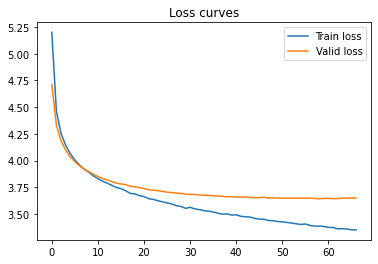

In [40]:
epochs = numpy.array(list(range(len(plot_cache))))
plt.plot(epochs, [i[0] for i in plot_cache], label='Train loss')
plt.plot(epochs, [i[1] for i in plot_cache], label='Valid loss')

plt.legend()
plt.title('Loss curves')
plt.show()

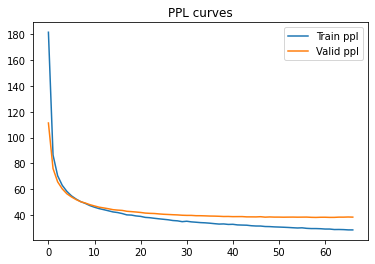

In [41]:
epochs = numpy.array(list(range(len(plot_cache))))
plt.plot(epochs, [2**(i[0]/numpy.log(2)) for i in plot_cache], label='Train ppl')
plt.plot(epochs, [2**(i[1]/numpy.log(2)) for i in plot_cache], label='Valid ppl')

plt.legend()
plt.title('PPL curves')
plt.show()

### Compare the results
#### Checking some trigram probabilities

In the previous lab we have this using 3gram count based LM:

$p( \text{dog }| \text{ my pet} ) = 0.03030$

$p( \text{zebra } | \text{ my pet} ) = 0.01515$

$p( \text{lion } | \text{ my pet} ) = 0$

The last trigram had $p=0$ since such trigram did not appear in the training corpus.

Lets check what we get using personachat dataset.

In [42]:
def get_prob_of_token_given_prefix(prefix, token):
    inp = persona_dict.encode_token_seq(prefix.split(' '))
    #print(inp)
    with torch.no_grad():
        model.eval()
        logits = model(torch.tensor([inp], dtype=torch.long).to(current_device))
        
    tokid = persona_dict.get_id(token)
    prob_distr = torch.softmax(logits[0,-1], dim=-1)
    return prob_distr[tokid]

prefix='my pet'

for w in ['dog', 'zebra', 'lion', 'hotdog', 'table', 'math', 'pizza']:
    prob = get_prob_of_token_given_prefix(prefix, w)
    print('p( {} | {} ) = {:.{prec}f}'.format(w, prefix, prob, prec=8))
    
print('====================')

prefix='<bos> i have a'

for w in ['dog', 'zebra', 'lion', 'hotdog', 'table', 'math', 'pizza']:
    prob = get_prob_of_token_given_prefix(prefix, w)
    print('p( {} | {} ) = {:.{prec}f}'.format(w, prefix, prob, prec=8))
    
print('====================')

prefix='i have'

for w in ['dog', 'zebra', 'lion', 'hotdog', 'table', 'math', 'pizza']:
    prob = get_prob_of_token_given_prefix(prefix, w)
    print('p( {} | {} ) = {:.{prec}f}'.format(w, prefix, prob, prec=8))

print('====================')

prefix='have'

for w in ['dog', 'zebra', 'lion', 'hotdog', 'table', 'math', 'pizza']:
    prob = get_prob_of_token_given_prefix(prefix, w)
    print('p( {} | {} ) = {:.{prec}f}'.format(w, prefix, prob, prec=8))

p( dog | my pet ) = 0.00360091
p( zebra | my pet ) = 0.00063178
p( lion | my pet ) = 0.00004970
p( hotdog | my pet ) = 0.00002596
p( table | my pet ) = 0.00002861
p( math | my pet ) = 0.00003056
p( pizza | my pet ) = 0.00003829
p( dog | <bos> i have a ) = 0.06960344
p( zebra | <bos> i have a ) = 0.00016325
p( lion | <bos> i have a ) = 0.00032840
p( hotdog | <bos> i have a ) = 0.00002465
p( table | <bos> i have a ) = 0.00001450
p( math | <bos> i have a ) = 0.00002590
p( pizza | <bos> i have a ) = 0.00027605
p( dog | i have ) = 0.00005810
p( zebra | i have ) = 0.00000022
p( lion | i have ) = 0.00000022
p( hotdog | i have ) = 0.00000029
p( table | i have ) = 0.00000070
p( math | i have ) = 0.00000164
p( pizza | i have ) = 0.00003808
p( dog | have ) = 0.00000301
p( zebra | have ) = 0.00000043
p( lion | have ) = 0.00000049
p( hotdog | have ) = 0.00000143
p( table | have ) = 0.00000090
p( math | have ) = 0.00000037
p( pizza | have ) = 0.00000082


In [43]:
def get_top_token_given_prefix(prefix):
    inp = persona_dict.encode_token_seq(prefix.split(' '))
    with torch.no_grad():
        model.eval()
        logits = model(torch.tensor([inp], dtype=torch.long).to(current_device))
        
    prob_distr = torch.softmax(logits[0,-1], dim=-1)
    sorted_best_probs, sorted_best_toks = torch.topk(prob_distr, 20)

    for i in range(sorted_best_toks.size(0)):
        print('p( {} | {} ) = {:.{prec}f}'.format(persona_dict.decode_idx_seq([sorted_best_toks[i]])[0], prefix, sorted_best_probs[i], prec=8))

    print(persona_dict.decode_idx_seq(sorted_best_toks))

get_top_token_given_prefix('<bos> I live in')

p( the | <bos> I live in ) = 0.20480631
p( florida | <bos> I live in ) = 0.06449958
p( california | <bos> I live in ) = 0.04631159
p( a | <bos> I live in ) = 0.04002793
p( your | <bos> I live in ) = 0.03340455
p( my | <bos> I live in ) = 0.03132324
p( texas | <bos> I live in ) = 0.02445629
p( ny | <bos> I live in ) = 0.01626381
p( canada | <bos> I live in ) = 0.01619168
p( japan | <bos> I live in ) = 0.01268912
p( chicago | <bos> I live in ) = 0.01215492
p( new | <bos> I live in ) = 0.01203236
p( portland | <bos> I live in ) = 0.01175667
p( kansas | <bos> I live in ) = 0.01038381
p( seattle | <bos> I live in ) = 0.00876119
p( georgia | <bos> I live in ) = 0.00813358
p( ohio | <bos> I live in ) = 0.00810100
p( this | <bos> I live in ) = 0.00755779
p( america | <bos> I live in ) = 0.00752445
p( france | <bos> I live in ) = 0.00744125
['the', 'florida', 'california', 'a', 'your', 'my', 'texas', 'ny', 'canada', 'japan', 'chicago', 'new', 'portland', 'kansas', 'seattle', 'georgia', 'ohio', 

In [44]:
# Save the model
# BE CAREFUL TO NOT OVERWRITE SOME IMPORTANT MODEL

if False:
    torch.save({
        'options': options,
        'loss_cache': plot_cache,
        'model_dict': model.state_dict()
    }, './static_files/persona_rnn_lm.pt')

---
## References
- Deep Learning book, chapter 10
- DS-GA 1011 NLP with Representation Learning Fall 2019